In [164]:
import numpy as np
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import cPickle

In [3]:
#base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/dev/"
#eers_dir = base_dir + "score_combination/score_single_phonemes/"
#features_combination_dir = base_dir + "features_combination/single/"
#output_dir = "/Users/lmatayoshi/Desktop/mail_bootstrapping/"
#output_dir_features_combination = output_dir + "features_combination/"
#output_dir_score_combination = output_dir + "score_combination/"

# Score combination

In [235]:
base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/dev/"
features_combination_dir = base_dir + "features_combination/single/"
score_combination_dir = base_dir + "score_combination/"
supervectors_single_phonemes_dir = score_combination_dir + "supervectors_single_phonemes/"
dct_single_phonemes_dir = score_combination_dir + "dct_single_phonemes/"
plots_dir = base_dir + "plots/"
score_combination_plots_dir = plots_dir + "score_combination/"
features_combination_plots_dir = plots_dir + "features_combination/"
barplots_dir = plots_dir + "barplots/"

In [166]:
phonemes = ["c", "x", "G", "d", "b", "g", "z", "w", "N", "B", "rr", "u", "p", "D", "y", "k", "m", "t", "l", "i", "r", "n", "s", "o", "a", "e"]

In [167]:
pvalues_score_combination_dict = {
    'B': "0.096",
    'D': "0.83",
    'G': "1.0",
    'N': "0.075",
    'Y': "1.0",
    'a': "0.0195",
    'b': "1.0",
    'c': "0.014",
    'd': "0.77",
    'e': "9.95e-06",
    'f': "0.0087",
    'g': "1.0",
    'i': "0.032",
    'k': "0.0126",
    'l': "0.001",
    'm': "0.0003",
    'n': "6.45e-05",
    'o': "1.97e-05",
    'p': "1.0",
    'r': "0.242",
    'rr': "0.136",
    's': "1.64e-09",
    't': "0.056",
    'u': "0.144",
    'w': "1.0",
    'x': "0.29",
    'y': "5.50e-10",
    'z': "0.004"
}

In [168]:
pvalues_features_combination_dict = {
    'B': "0.46",
    'D': "1.0",
    'G': "1.0",
    'N': "0.123",
    'a': "0.868",
    'b': "1.0",
    'c': "0.0002",
    'd': "0.74",
    'e': "0.0024",
    'g': "1.0",
    'i': "0.35",
    'k': "0.146",
    'l': "0.007",
    'm': "0.002",
    'n': "9.45e-07",
    'o': "0.017",
    'p': "1.0",
    'r': "0.253",
    'rr': "0.024",
    's': "5.28e-20",
    't': "0.18",
    'u': "0.298",
    'w': "1.0",
    'x': "0.052",
    'y': "3.87e-05",
    'z': "0.48"
}

In [169]:
def load_dev_speakers():
	speakers_filename = base_dir + "dev_speakers"
	with open(speakers_filename, "r") as f:
		speakers = [line.rstrip() for line in f.readlines()]
	return speakers

In [170]:
def all_phonemes_empty_dict(phonemes):
    return dict(zip(phonemes, [[] for p in phonemes]))

In [171]:
def load_positives_negatives_dict():
    phonemes = [ "Y", "f", "c", "x", "G", "d", "b", "g", "z", "w", "N", "B", "rr", "u", "p", "D", "y", "k", "m", "t", "l", "i", "r", "n", "s", "o", "a", "e"]
    positive_values = [ 53, 682, 405, 590, 222, 773, 528, 887, 189, 743, 911, 428, 491, 1948, 1657, 920, 2453, 1708, 3234, 2938, 3505, 4929, 3650, 7152, 7555, 8040, 10144, 10597]
    positive_values = [str(v) for v in positive_values]
    negative_values = [10, 10, 105, 153, 643, 89, 395, 114, 997, 500, 443, 1169, 1739, 482, 1055, 2009, 574, 1472, 686, 1542, 1373, 1238, 2617, 476, 480, 2077, 2069, 3484 ]
    negative_values = [str(v) for v in negative_values]
    positives_dict = dict(zip(phonemes, positive_values))
    negatives_dict = dict(zip(phonemes, negative_values))
    return (positives_dict, negatives_dict)

In [172]:
def check_logids(lines_supervectors, lines_second_source):
    logids_supervectors = [l[0] for l in lines_supervectors]
    logids_second_source = [l[0] for l in lines_second_source]
    if not logids_supervectors == logids_second_source:
        raise Exception(phoneme + " logids doesn't match in supervectors vs second source")
    

In [173]:
def label_for(label):
    if label == "True":
        return 1
    elif label == "False":
        return -1

In [174]:
def compute_EER(tuples):
    labels = [t[1] for t in tuples]
    hyperplane_distances = [t[0] for t in tuples]
    fpr, tpr, _ = roc_curve(labels, hyperplane_distances)
    # eer is where fpr is equal to fnr
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [175]:
def lines_for_speaker(lines, speaker):
    return [line for line in lines if speaker in line[0]]

In [176]:
def generate_shuffled_speakers_list(speakers, n):
    res = []
    for i in range(n):
        res.append(shuffled_with_replacement(speakers))
    return res

In [177]:
def shuffled_with_replacement(speakers):
	n_speakers = len(speakers)
	shuffled_indexes_with_replacement = np.random.randint(n_speakers, size=n_speakers)
	return [speakers[j] for j in shuffled_indexes_with_replacement]

Para cada fonema, combino scores utilizando como factor el diccionario pasado por parámetro.

In [178]:
def main(eers_dir, second_source, proportion_dict):
    ### Dictionary generation 
    dev_speakers = load_dev_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(dev_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = supervectors_single_phonemes_dir
    second_source_dir = dct_single_phonemes_dir
    #supervectors_dir = eers_dir + "supervectors/"
    #second_source_dir = eers_dir + second_source + "/"
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        second_source_filename = second_source_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        with open(second_source_filename, "r") as f_second_source:
            lines_second_source = f_second_source.readlines()
            lines_second_source = [l.split(" ") for l in lines_second_source]
        check_logids(lines_supervectors, lines_second_source)
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            new_lines_second_source = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
                new_lines_second_source = new_lines_second_source + lines_for_speaker(lines_second_source, speaker)
            check_logids(new_lines_supervectors, new_lines_second_source)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) + proportion_dict[original_phoneme]*float(new_lines_second_source[i][4])
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [179]:
def main_single_source(eers_dir, features_combination_type):
    ### Dictionary generation 
    dev_speakers = load_dev_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(dev_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = features_combination_dir
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) 
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [180]:
score_combination_factor_dict = {
    'Y': 0.8,
    'c': 0.9,
    'f': 0.4,
    'x': 0.6,
    'd': 0.2,
    'G': 0.1,
    'b': 0.1,
    'g': 0.1,
    'z': 0.3,
    'w': 0.0,
    'N': 1.0,
    'B': 0.3,
    'rr': 0.9,
    'u': 1.0,
    'p': 0.0,
    'D': 0.1,
    'y': 1.0,
    'k': 0.2,
    'm': 0.6,
    't': 0.6,
    'l': 0.8,
    'i': 0.3,
    'r': 0.6,
    'n': 0.7,
    's': 1.0,
    'o': 0.9,
    'a': 0.7,
    'e': 0.6
}

In [57]:
#supervectors_dct = main(None, None, score_combination_factor_dict)
#supervectors = main_single_source(None, None)
#features_combination = main_single_source(None, None)

In [181]:
dicts_dir = base_dir + "dicts/"
supervectors_dict_filename = dicts_dir + "supervectors_dict"
score_combination_dict_filename = dicts_dir +"score_combination_dict"
features_combination_dict_filename = dicts_dir +"features_combination_dict"

with open(supervectors_dict_filename, "rb") as f:
    supervectors = cPickle.load(f)
with open(score_combination_dict_filename, "rb") as f:
    score_combination = cPickle.load(f)
with open(features_combination_dict_filename, "rb") as f:
    features_combination = cPickle.load(f)

# Results analysis

In [182]:
for phoneme in phonemes:
    print "Phone: " + phoneme
    print "Supervectors: " + str(np.mean(supervectors[phoneme]))
    print "Score combination: " + str(np.mean(score_combination[phoneme]))
    print "Features combination: " + str(np.mean(features_combination[phoneme]))
    print "\n"

Phone: c
Supervectors: 0.447843010907
Score combination: 0.397000804029
Features combination: 0.377994546655


Phone: x
Supervectors: 0.163101536944
Score combination: 0.159634030514
Features combination: 0.162013384411


Phone: G
Supervectors: 0.166272884218
Score combination: 0.165292715064
Features combination: 0.166931272681


Phone: d
Supervectors: 0.362732921639
Score combination: 0.359961028301
Features combination: 0.36905959706


Phone: b
Supervectors: 0.122064414231
Score combination: 0.123711347201
Features combination: 0.122167834387


Phone: g
Supervectors: 0.234178847851
Score combination: 0.234079069852
Features combination: 0.235517386164


Phone: z
Supervectors: 0.220083164731
Score combination: 0.212934336184
Features combination: 0.221531710787


Phone: w
Supervectors: 0.151820297868
Score combination: 0.153023703266
Features combination: 0.152841412827


Phone: N
Supervectors: 0.216939594048
Score combination: 0.203285258234
Features combination: 0.204432581475


Ph

# Histograms

In [183]:
def text_for_delta(number):
    if number > 0:
        return "improvement"
    else:
        return "degradation"

In [184]:
def plot_and_save_histogram(supervectors, score_combination, phoneme, label, title_info, output_filename=None):
    n_bins = 30
    #counts_positives_negatives, bins_positives_negatives, patches_positives_negatives = plt.hist(positives_negatives_distances, n_bins)
    counts_both, bins_both, _ = plt.hist(supervectors + score_combination, n_bins)

    ################
    # SUPERVECTORS # 
    ################

    n_supervectors, bins_supervectors, _ = plt.hist(supervectors, bins=bins_both)
    plt.clf()
    #normalized_positives = n_positives/total_positives

    #####################
    # SCORE COMBINATION #
    #####################

    n_score_combination, bins_score_combination, _ = plt.hist(score_combination, bins=bins_both)
    #normalized_negatives = n_negatives/total_negatives

    fixed_bins = []
    for i in range(0, len(bins_both) - 1):
        mean = (bins_both[i] + bins_both[i+1]) / 2
        fixed_bins.append(mean)

    plt.clf()
    
    supervectors_mean = np.mean(supervectors)
    combination_mean = np.mean(score_combination)
    delta = (supervectors_mean - combination_mean) / supervectors_mean
    delta_text = "%.2f" % np.abs(delta) + "% " #+ text_for_delta(delta)
    p_value_text = "P-value: " + title_info['p-value']
    positive_negatives_text = "Positives: " + title_info['n_positives'] + ", Negatives: " + title_info['n_negatives']
    plt.title("'" + phoneme + "', " + delta_text + ", " + p_value_text + ", " + positive_negatives_text )
    #plt.figure(figsize= (22,7))
    plt.plot(fixed_bins, n_supervectors, color="blue", label="supervectors")   
    plt.plot(fixed_bins, n_score_combination, color="red", label= label)
    plt.axvline(x=supervectors_mean, linestyle="--", linewidth=0.5, color="blue")
    plt.axvline(x=combination_mean, linestyle="--", linewidth=0.5, color="red")
    plt.legend()
    plt.xticks(fixed_bins, rotation='vertical')
    plt.tight_layout()
    plt.xlabel("EER")
    plt.ylabel("count")
    if output_filename:
        plt.savefig(output_filename)
    plt.show()


In [185]:
def barplot(supervectors, eers):
    eers = np.array(eers)
    trimmed_eers = eers
    n_instances = eers.shape[0]
    n_trim_each_tail = int((2.5 * 1000) / 100)
    trimmed_eers = np.sort(eers)
    trimmed_eers = trimmed_eers[n_trim_each_tail: -n_trim_each_tail]
    mean = np.mean(eers)
    min_error = np.abs(mean - np.min(trimmed_eers))
    max_error = np.abs(mean - np.max(trimmed_eers))
    
    supervectors = np.array(supervectors)
    trimmed_supervectors = supervectors
    n_instances = supervectors.shape[0]
    n_trim_each_tail = int((2.5 * 1000) / 100)
    trimmed_supervectors = np.sort(supervectors)
    trimmed_supervectors = trimmed_supervectors[n_trim_each_tail: -n_trim_each_tail]
    mean_supervectors = np.mean(supervectors)
    min_error_supervectors = np.abs(mean_supervectors - np.min(trimmed_supervectors))
    max_error_supervectors = np.abs(mean_supervectors - np.max(trimmed_supervectors))
    
    plt.bar([1], [mean], width=0.5, yerr=[[min_error],[max_error]], capsize=7)
    plt.bar([2], [mean_supervectors], width=0.5, yerr=[[min_error_supervectors],[max_error_supervectors]], capsize=7)
    plt.show()

# Barplot

In [199]:
phonemes_by_kappa = ["b", "m", "B", "s", "D", "G", "w", "i", "y", "p", "r", "z", "t", "k", "rr", "a", "o", "l", "e", "n", "u", "c", "x", "d", "g", "N"]

In [200]:
def calculate_tuple(eers):
    eers = np.array(eers)
    trimmed_eers = eers
    n_instances = eers.shape[0]
    n_trim_each_tail = int((2.5 * n_instances) / 100)
    trimmed_eers = np.sort(eers)
    trimmed_eers = trimmed_eers[n_trim_each_tail: -n_trim_each_tail]
    mean = np.mean(eers)
    min_error = np.abs(mean - np.min(trimmed_eers))
    max_error = np.abs(mean - np.max(trimmed_eers))
    return {"mean": mean, "min": min_error, "max": max_error}

In [201]:
def empty_model_entry():
    return {"mean": None, "min": None, "max": None}

In [202]:
barplot_values = [{"supervectors": empty_model_entry(), "features_combination": empty_model_entry(), "score_combination": empty_model_entry()} for p in phonemes]
barplot_dicc = dict(zip(phonemes_by_kappa, barplot_values))

In [247]:
def plot_barplots(phonemes, title, filename=None):
    for p in phonemes:
        barplot_dicc[p]["supervectors"] = calculate_tuple(supervectors[p])
        barplot_dicc[p]["features_combination"] = calculate_tuple(features_combination[p])
        barplot_dicc[p]["score_combination"] = calculate_tuple(score_combination[p])
        
    min_yerr_supervectors = [barplot_dicc[p]["supervectors"]["min"] for p in phonemes]
    max_yerr_supervectors = [barplot_dicc[p]["supervectors"]["max"] for p in phonemes]

    min_yerr_features_combination = [barplot_dicc[p]["features_combination"]["min"] for p in phonemes]
    max_yerr_features_combination = [barplot_dicc[p]["features_combination"]["max"] for p in phonemes]

    min_yerr_score_combination = [barplot_dicc[p]["score_combination"]["min"] for p in phonemes]
    max_yerr_score_combination = [barplot_dicc[p]["score_combination"]["max"] for p in phonemes]
    
    barWidth = 0.4
    xs_1 = np.arange(len(phonemes)) * 1.6
    xs_2 = [x + barWidth for x in xs_1]
    xs_3 = [x + 2*barWidth for x in xs_1]

    ys_1 = [barplot_dicc[p]["supervectors"]["mean"] for p in phonemes]
    ys_2 = [barplot_dicc[p]["features_combination"]["mean"] for p in phonemes]
    ys_3 = [barplot_dicc[p]["score_combination"]["mean"] for p in phonemes]
    plt.bar(xs_1, ys_1, width=barWidth, color="blue", yerr=[min_yerr_supervectors, max_yerr_supervectors], capsize=2, label="supervectors")
    plt.bar(xs_2, ys_2, width=barWidth, color="violet", yerr=[min_yerr_features_combination, max_yerr_features_combination], capsize=2, label="features combination")
    plt.bar(xs_3, ys_3, width=barWidth, color="red", yerr=[min_yerr_score_combination, max_yerr_score_combination], capsize=2, label="score combination")
    plt.xticks(xs_2, phonemes)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.savefig(filename)
    plt.show()

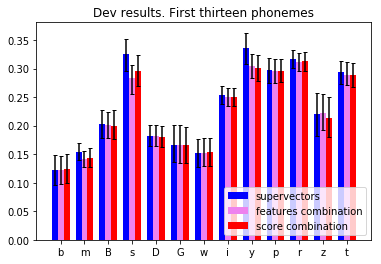

In [240]:
title = "Dev results. First thirteen phonemes"
output_filename = barplots_dir + "dev_part_1"
plot_barplots(phonemes_by_kappa[:13], title, filename=output_filename)

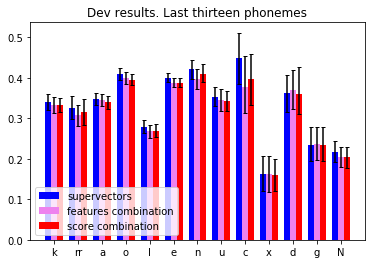

In [248]:
title = "Dev results. Last thirteen phonemes"
output_filename = barplots_dir + "dev_part_2"
plot_barplots(phonemes_by_kappa[13:], title, filename=output_filename)

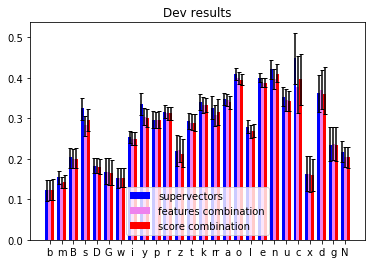

In [244]:
title = "Dev results"
output_filename = barplots_dir + "dev_all"
plot_barplots(phonemes_by_kappa, title, filename=output_filename)

In [203]:
for p in phonemes_by_kappa:
    barplot_dicc[p]["supervectors"] = calculate_tuple(supervectors[p])
    barplot_dicc[p]["features_combination"] = calculate_tuple(features_combination[p])
    barplot_dicc[p]["score_combination"] = calculate_tuple(score_combination[p])

In [204]:
min_yerr_supervectors = [barplot_dicc[p]["supervectors"]["min"] for p in phonemes]
max_yerr_supervectors = [barplot_dicc[p]["supervectors"]["max"] for p in phonemes]

min_yerr_features_combination = [barplot_dicc[p]["features_combination"]["min"] for p in phonemes]
max_yerr_features_combination = [barplot_dicc[p]["features_combination"]["max"] for p in phonemes]

min_yerr_score_combination = [barplot_dicc[p]["score_combination"]["min"] for p in phonemes]
max_yerr_score_combination = [barplot_dicc[p]["score_combination"]["max"] for p in phonemes]

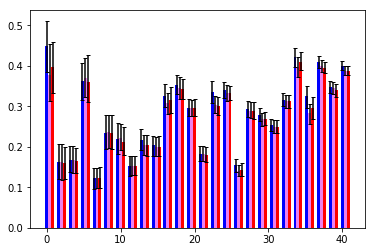

In [205]:
barWidth = 0.4
xs_1 = np.arange(len(phonemes)) * 1.6
xs_2 = [x + barWidth for x in xs_1]
xs_3 = [x + 2*barWidth for x in xs_1]

ys_1 = [barplot_dicc[p]["supervectors"]["mean"] for p in phonemes]
ys_2 = [barplot_dicc[p]["features_combination"]["mean"] for p in phonemes]
ys_3 = [barplot_dicc[p]["score_combination"]["mean"] for p in phonemes]
plt.bar(xs_1, ys_1, width=barWidth, color="blue", yerr=[min_yerr_supervectors, max_yerr_supervectors], capsize=2)
plt.bar(xs_2, ys_2, width=barWidth, color="violet", yerr=[min_yerr_features_combination, max_yerr_features_combination], capsize=2)
plt.bar(xs_3, ys_3, width=barWidth, color="red", yerr=[min_yerr_score_combination, max_yerr_score_combination], capsize=2)
plt.show()

# Score combination

In [83]:
positives_dict, negatives_dict = load_positives_negatives_dict()

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/dev/plots/score_combination/s


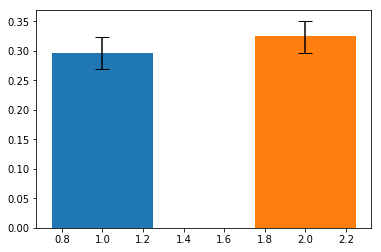

In [98]:
for p in phonemes:
    output_phoneme = p
    if p in ['g', 'y', 'd', 'b', 'n']:
        output_phoneme = p + "_lowercase"
    output_filename = score_combination_plots_dir + output_phoneme
    print output_filename
    title_info = {
        'n_positives': positives_dict[p], 
        'n_negatives': negatives_dict[p], 
        'p-value': pvalues_score_combination_dict[p]
    }
    plot_and_save_histogram(supervectors[p], score_combination[p], p, "score_combination", title_info, output_filename=output_filename)

# Features combination

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/dev/plots/features_combination/s


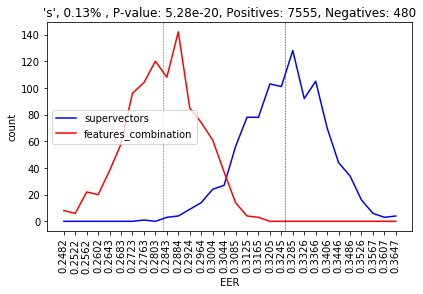

In [33]:
for p in phonemes:
    output_phoneme = p
    if p in ['g', 'y', 'd', 'b', 'n']:
        output_phoneme = p + "_lowercase"
    output_filename = features_combination_plots_dir + output_phoneme
    print output_filename
    title_info = {
        'n_positives': positives_dict[p], 
        'n_negatives': negatives_dict[p], 
        'p-value': pvalues_features_combination_dict[p]
    }
    plot_and_save_histogram(supervectors[p], features_combination[p], p, "features_combination", title_info, output_filename=output_filename)